## Install dependencies

In [1]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np
import requests
import os
import logging
import sys
import optuna
import joblib
import xgboost as xgb

c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from ta import add_all_ta_features

In [38]:
import matplotlib.pyplot as plt
import matplotlib

## Variables

In [3]:
current_storage = os.path.join("d:", "data")
vn30f_storage = os.path.join(current_storage, 'vn30f')

In [4]:
start_time = 0
now_time = 9999999999
symbol = 'VN30F1M'
rolling_window = 1 # Số phút muốn dự đoán tiếp theo

In [5]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "btc1-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

## Formulas

In [6]:
def choose_position(roi, trade_threshold = 0.0005):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

In [7]:
def backtest_position_ps(position, price, percentage, periods):
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(periods).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*0.01

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

In [8]:
def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

In [9]:
def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, fee_perc, periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 24)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

In [10]:
def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

# Function for data

In [11]:
def scale_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

In [12]:
def split_data(data):
    """
    Hàm này chia dữ liệu thành 2 phần: tập huấn luyện và tập hold out.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu tập huấn luyện.
    pandas.DataFrame: DataFrame chứa dữ liệu tập giữ lại.
    """
    # Chia dữ liệu thành 3 phần
    new_part = np.array_split(data, 3)

    # Access each part individually
    hold_out = new_part[2]
    train_data = pd.concat([new_part[0], new_part[1]], axis=0)

    return train_data, hold_out

def split_optuna_data(data):
    """
    Hàm này chia dữ liệu thành các tập train và test để sử dụng trong quá trình tối ưu hóa bằng Optuna.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu train (đã được chuẩn hóa).
    pandas.DataFrame: DataFrame chứa dữ liệu test (đã được chuẩn hóa).
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu train.
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu test.
    """
    # Chia dữ liệu thành tập train và tập hold out
    train_data, _ = split_data(data)
    
    # Loại bỏ các cột không cần thiết
    if 'Open' in train_data.columns:
        optuna_data = train_data.drop(['Open','High','Low','Close','Volume', 'Return', 'Date', 'time'], axis=1)
    else:
        optuna_data = train_data.drop(['Close', 'Return', 'Date', 'time'], axis=1)
    
    # Chuẩn hóa dữ liệu
    optuna_data = scale_data(optuna_data)
    
    # Chia dữ liệu thành tập train và tập test
    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['Return'], test_size=0.5, shuffle=False)

    return X_train, X_valid, y_train, y_valid, train_data

## Get data

In [13]:
def get_vn30f(start_time, now_time, symbol):
    def vn30f():
            return requests.get(f"https://services.entrade.com.vn/chart-api/chart?from={start_time}&resolution=1&symbol={symbol}&to={now_time}").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    ohlc_dict = {                                                                                                             
        'Open': 'first',                                                                                                    
        'High': 'max',                                                                                                       
        'Low': 'min',                                                         
        'Close': 'last',                                                                                                    
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    dt_object = datetime.utcfromtimestamp(start_time) + timedelta(hours = 7)
    now_object = datetime.utcfromtimestamp(now_time) + timedelta(hours = 7)

    print(f'===> Data {symbol} from {dt_object} to {now_object} has been appended ')
    
    return vn30fm

In [14]:
df = get_vn30f(start_time, now_time, symbol)

===> Data VN30F1M from 1970-01-01 07:00:00 to 2286-11-21 00:46:39 has been appended 


In [15]:
data = df.copy()

## Preprocess

In [16]:
from scipy.stats.mstats import winsorize
# Áp dụng Winsorization
data['Close'] = winsorize(data['Close'], limits=[0.05, 0.05])

In [17]:
def process_data(data):
    data.set_index('Date', inplace =True)
    data.columns = ['Open','High','Low','Close','Volume']

    data['Date'] = [str(i)[:10] for i in data.index]
    data['time'] = [str(i)[11:] for i in data.index]

    data = data[~data.index.duplicated(keep='first')] # Handling duplicate
    data_model = data.pivot(index = 'Date', columns = 'time', values = ['Open','High','Low','Close','Volume']).ffill(axis = 1).stack().reset_index() # Handling missing values
    # data_model.columns = ['Date','time','Close']

    return data_model

In [18]:
data = process_data(data)

In [19]:
data

,Date,time,Open,High,Low,Close,Volume
0,2018-08-13,09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13,09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13,09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13,09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13,09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...,...
322807,2024-06-06,14:27:00,1293.7,1294.8,1293.0,1294.4,3263.0
322808,2024-06-06,14:28:00,1294.9,1295.6,1294.8,1295.0,2860.0
322809,2024-06-06,14:29:00,1294.8,1295.6,1294.1,1295.6,2310.0
322810,2024-06-06,14:30:00,1294.9,1294.9,1294.9,1294.9,503.0


## Create features

In [20]:
def generate_features(df, shift=1):
    """
    Hàm này tạo ra các features mới từ dữ liệu cổ phiếu.

    Args:
    df (pandas.DataFrame): DataFrame chứa dữ liệu cần tạo features, có các cột 'open', 'high', 'low', 'close' và 'volume'.

    Returns:
    pandas.DataFrame: DataFrame đã được mở rộng với các features mới.
    """

    # Thêm tất cả các đặc trưng kỹ thuật từ thư viện TA-Lib
    df_shift = df.shift(shift)
    df_shift = add_all_ta_features(df_shift, open="Open", high="High", low="Low", close="Close", volume="Volume")

    # Drop the original OHLCV columns from the shifted DataFrame
    df_shift = df_shift.drop(columns=['Date','time', 'Open','High','Low','Close','Volume'])

    df = pd.concat([df, df_shift], axis=1)

    ### Ví dụ các features thêm tay
    # Tính phần trăm thay đổi của giá đóng cửa trong 5 phút
    df['Trend_5min'] = df['Close'].shift(shift).pct_change(periods=5)

    # Tính độ lệch chuẩn của giá đóng cửa trong 30 phút
    df['Std_Rolling_30min'] = df['Close'].shift(shift).rolling(window=30, min_periods=1).std()

    # Tính độ lệch của giá đóng cửa so với trung bình động 30 phút
    ma_30min = df['Close'].shift(shift).rolling(window=30, min_periods=1).mean()
    df['Close_Minus_MA_30min'] = df['Close'].shift(shift) - ma_30min

    # Tính trung bình động 10 phút của giá đóng cửa
    df['SMA_10'] = df['Close'].shift(shift).rolling(window=10, min_periods=1).mean()

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Replace infinite values with NaN in numeric columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

    # Điền các giá trị NaN với 0
    df = df.fillna(0)

    return df

In [21]:
data  = generate_features(data)

c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


Thêm các feature khác, ví dụ giá vàng (xem xét phù hợp với thời gian trong data)

# Add Predict Features

In [22]:
data['Return'] = (data['Close'].shift(-rolling_window) - data['Close'])/data['Close']
data = data.fillna(0)
data = data.drop(index=0)
data

,Date,time,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,...,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,Trend_5min,Std_Rolling_30min,Close_Minus_MA_30min,SMA_10,Return
1,2018-08-13,09:01:00,943.0,943.1,942.9,943.1,220.0,-975.000000,975.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,942.900000,0.000424
2,2018-08-13,09:02:00,943.0,943.6,943.0,943.5,121.0,-755.000000,1195.0,0.000000,...,0.000000,0.000000,0.021211,0.021209,0.0,0.000000,0.141421,0.100000,943.000000,-0.000106
3,2018-08-13,09:03:00,943.3,943.4,943.3,943.4,135.0,-674.333333,1316.0,0.000000,...,0.000000,0.000000,0.042413,0.042404,0.0,0.000000,0.305505,0.333333,943.166667,-0.000318
4,2018-08-13,09:04:00,943.2,943.2,943.0,943.1,361.0,-539.333333,1181.0,0.000000,...,0.000000,0.000000,-0.010599,-0.010599,0.0,0.000000,0.275379,0.175000,943.225000,-0.000106
5,2018-08-13,09:05:00,943.1,943.1,942.9,943.0,343.0,-539.333333,820.0,0.000000,...,0.000000,0.000000,-0.031800,-0.031805,0.0,0.000000,0.244949,-0.100000,943.200000,0.000106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322807,2024-06-06,14:27:00,1293.7,1294.8,1293.0,1294.4,3263.0,0.000000,38070877.2,-0.324495,...,4.103433,1295.302998,0.077369,0.077340,0.0,-0.001467,2.493645,-4.763333,1296.620000,0.000464
322808,2024-06-06,14:28:00,1294.9,1295.6,1294.8,1295.0,2860.0,0.000000,38074140.2,-0.259406,...,3.577669,1295.129961,0.069579,0.069554,0.0,-0.001080,2.591456,-3.743333,1295.870000,0.000463
322809,2024-06-06,14:29:00,1294.8,1295.6,1294.1,1295.6,2310.0,0.000000,38077000.2,-0.297875,...,1.982627,1295.112102,0.046354,0.046343,0.0,0.000077,2.654175,-3.046667,1295.270000,-0.000540
322810,2024-06-06,14:30:00,1294.9,1294.9,1294.9,1294.9,503.0,0.000000,38079310.2,-0.205406,...,-0.509211,1295.155118,0.046332,0.046321,0.0,0.001391,2.681473,-2.326667,1294.830000,0.002935


# Feature Engineering

In [23]:
def drop_high_corr_columns(df, threshold=0.6):
    ohlcv_columns = {'Date','time', 'Open','High','Low','Close','Volume'}

     # Identify non-OHLCV and non-date/time columns
    non_corr_columns = [col for col in df.columns if col not in ohlcv_columns]

    # Compute the correlation matrix only for non-OHLCV and non-date/time columns
    corr_matrix = df[non_corr_columns].corr().abs()

    # Create a set to keep track of columns to drop
    to_drop = set()

    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # If the correlation is higher than the threshold, mark the column with the higher index to drop
                col_to_drop = corr_matrix.columns[j]
                if col_to_drop not in ohlcv_columns:
                    to_drop.add(col_to_drop)

    # Drop the columns from the DataFrame
    df_dropped = df.drop(columns=to_drop)
    return df_dropped

data = drop_high_corr_columns(data)

In [24]:
def objective(trial, X_train, X_valid, y_train, y_valid, y_price):

    # Select features based on Optuna's suggestions
    selected_features = []
    for col in X_train.columns:
        if trial.suggest_categorical(col, [0, 1]):
            selected_features.append(col)

    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue

    # trade_threshold = trial.suggest_float('trade_threshold', 0.008, 0.08, step=0.0004)
    trade_threshold  = 0.0005

    # Use only the selected features in training
    X_train_selected = X_train[selected_features]
    X_valid_selected = X_valid[selected_features]

    # Train the model
    model = xgb.XGBRegressor()
    model.fit(X_train_selected, y_train)

    y_pred_train = model.predict(X_train_selected)
    y_pred_valid = model.predict(X_valid_selected)

    _, pos_is, _, sharpe_is = sharpe_for_vn30f(y_pred_train, y_price[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, pos_os, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_price[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print('Trade times in sample:',len(pos_is[pos_is != 0]), 'Trade times out sample:',len(pos_os[pos_os != 0]))

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

X_train, X_valid, y_train, y_valid, train_data = split_optuna_data(data)

In [ ]:
"""## Define number of trials (no 2)"""

# Create a study object and optimize the objective function
study = optuna.create_study(directions=['maximize', 'minimize'])
unique_trials = 50

while unique_trials > len(set(str(t.params) for t in study.trials)):
    study.optimize(lambda trial: objective(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)
    study.trials_dataframe().sort_values('values_0').to_csv('feature_trials.csv')
    joblib.dump(study, 'abmodel.pkl')
    
trials = study.trials
trials.sort(key=lambda trial: trial.values, reverse=True)
study.trials_dataframe().sort_values('values_0', ascending=False).duplicated().sum()

"""## Checking part for fixing bug"""
df =study.trials_dataframe()

# df.to_csv('save_trials.csv')

Retrieve Top PNL

In [28]:
trials = study.trials

# Sort trials based on objective values
trials.sort(key=lambda trial: trial.values, reverse=True)

# Define top pnl to take for clustering
top_trials = trials[:100]

new_df_no_close_col = data.drop(['Date','time', 'Open','High','Low','Close','Volume', 'Return' ], axis=1)

# Extract hyperparameters from top trials
top_features_list = []

for trial in top_trials:
  best_selected_features = [col for col in new_df_no_close_col.columns if trial.params[col] == 1]
  top_features_list.append(best_selected_features)

In [31]:
top_pnl = []
trade_threshold  = 0.0005

for best_selected_features in top_features_list:

    new_df_selected = data[['Close', 'Return']+best_selected_features]
    train_select_col_data, _ = split_data(new_df_selected)

    retrain_data = train_select_col_data.drop(['Close', 'Return'], axis=1)
    retrain_data = scale_data(retrain_data)

    X_train, X_valid, y_train, y_valid = train_test_split(retrain_data,
                                                      train_select_col_data['Return'],
                                                      test_size=0.5,shuffle=False)

    # Create and train model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_valid = model.predict(X_valid)
    _, pnl_valid, _, _ = sharpe_for_vn30f(y_pred_valid, y_valid, trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    pnl_valid_no_nan = np.nan_to_num(pnl_valid, nan=0)
    top_pnl.append(pnl_valid_no_nan)

# ONC

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [36]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0)/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")

    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)

    return corr1, clstrs, silh_coef_optimal

def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])

    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])

    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]

    dist = ((1 - corr0) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i

    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)

    return corrNew, clstrsNew, silhNew

def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1

    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = np.sum(list(clusterTstats.values()))/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else:
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew
            #return corr1, clstrs, silh, stat

In [37]:
# FREQUENCY FEATURE TABLE
correlation_matrix = np.corrcoef(top_pnl)
corr = pd.DataFrame(correlation_matrix)

maxNumClusters25
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1] clstrs len:2
Cluster 0:
Cluster 1:


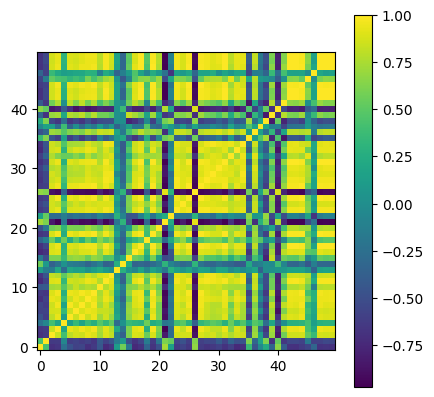

maxNumClusters25
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1] clstrs len:2


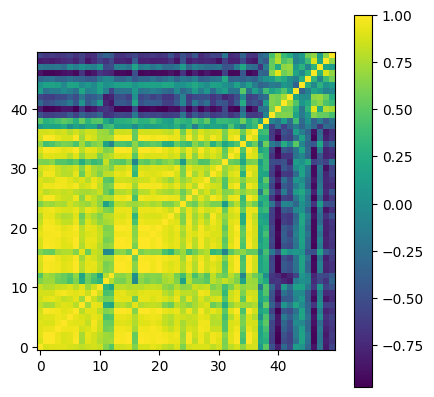

In [39]:
#Draw ground truth
matplotlib.pyplot.matshow(corr) #invert y-axis to get origo at lower left corner
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

#draw prediction based on ONC
corrNew, clstrsNew, silhNew = clusterKMeansTop(corr)
matplotlib.pyplot.matshow(corrNew)
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [42]:
for cluster_number, cluster_indices in clstrsNew.items():
    print(f"Cluster {cluster_number}:")
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        trial_params = top_trials[idx].params
        print(f"- Trial {trial_number}: {trial_params}")

Cluster 0:
- Trial 8: {'volume_adi': 1, 'volume_obv': 1, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_vpt': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kcp': 0, 'volatility_kchi': 1, 'trend_macd': 1, 'trend_macd_diff': 1, 'trend_vortex_ind_neg': 1, 'trend_mass_index': 1, 'trend_dpo': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}
- Trial 11: {'volume_adi': 0, 'volume_obv': 0, 'volume_cmf': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_vpt': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kcp': 0, 'volatility_kchi': 0, 'trend_macd': 1, 'trend_macd_diff': 0, 'trend_vortex_ind_neg': 0, 'trend_mass_index': 0,

In [43]:
import pandas as pd

cluster_frequencies = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_features = top_trials[idx].number
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1],  reverse=True)

    print(f"Cluster {cluster_number}:")
    top_features = sorted_frequency[:10]
    df = pd.DataFrame(top_features, columns=['Feature', 'Frequency'])
    print(df)


Cluster 0:
             Feature  Frequency
0         volume_obv         32
1         volume_adi         23
2          others_dr         23
3   trend_aroon_down         22
4  momentum_pvo_hist         22
5     volatility_bbw         21
6    trend_psar_down         21
7          trend_dpo         21
8         volume_cmf         20
9          trend_adx         20
Cluster 1:
                     Feature  Frequency
0              volume_sma_em         10
1             volatility_bbw         10
2                 volume_vpt          9
3  trend_psar_down_indicator          9
4           trend_mass_index          8
5              trend_psar_up          8
6                 volume_cmf          7
7           trend_aroon_down          7
8    trend_psar_up_indicator          7
9                  volume_fi          7


In [44]:
cluster_lists = []

# Iterate through each cluster and its members
for cluster_number, cluster_indices in clstrsNew.items():
    cluster_list = []

    # Iterate through each index in the cluster
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        cluster_list.append(trial_number)

    cluster_lists.append(cluster_list)

# Print the lists for each cluster
for i, cluster_list in enumerate(cluster_lists):
    print(f"Cluster {i}: {cluster_list}")

Cluster 0: [8, 11, 25, 24, 35, 1, 14, 49, 34, 44, 5, 28, 46, 17, 37, 3, 45, 20, 38, 31, 0, 36, 47, 30, 48, 42, 6, 13, 21, 12, 18, 27, 23, 19, 26, 2, 7]
Cluster 1: [22, 41, 40, 4, 29, 33, 10, 9, 32, 43, 15, 16, 39]


In [45]:
top_10_features_per_cluster = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_cluster_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1], reverse=True)
    top_10_features_cluster = [feature for feature, _ in sorted_cluster_frequency[:10]]
    top_10_features_per_cluster.append(top_10_features_cluster)
    print(f"Top 10 features for Cluster {cluster_number}: {top_10_features_cluster}")

Top 10 features for Cluster 0: ['volume_obv', 'volume_adi', 'others_dr', 'trend_aroon_down', 'momentum_pvo_hist', 'volatility_bbw', 'trend_psar_down', 'trend_dpo', 'volume_cmf', 'trend_adx']
Top 10 features for Cluster 1: ['volume_sma_em', 'volatility_bbw', 'volume_vpt', 'trend_psar_down_indicator', 'trend_mass_index', 'trend_psar_up', 'volume_cmf', 'trend_aroon_down', 'trend_psar_up_indicator', 'volume_fi']


In [46]:
top_10_features_per_cluster

[['volume_obv',
  'volume_adi',
  'others_dr',
  'trend_aroon_down',
  'momentum_pvo_hist',
  'volatility_bbw',
  'trend_psar_down',
  'trend_dpo',
  'volume_cmf',
  'trend_adx'],
 ['volume_sma_em',
  'volatility_bbw',
  'volume_vpt',
  'trend_psar_down_indicator',
  'trend_mass_index',
  'trend_psar_up',
  'volume_cmf',
  'trend_aroon_down',
  'trend_psar_up_indicator',
  'volume_fi']]

In [47]:
top10_feat = pd.DataFrame(top_10_features_per_cluster)

In [48]:
selected_columns_cluster = []
for item in top_10_features_per_cluster:
  selected_columns = new_df_no_close_col.loc[:, item]
  selected_columns_cluster.append(selected_columns)

# Model selection

## Custom Early Stopping

In [51]:
from xgboost import callback

In [52]:
min_delta = 0.0001
patience = 30


class CustomEarlyStopping(callback.TrainingCallback):
    def __init__(self, min_delta, patience, verbose=False):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.best_score = np.inf
        self.wait = 0
        self.stopped_epoch = 0

    def after_iteration(self, model, epoch, evals_log):
        if not evals_log:
            return False
        metric_name = next(iter(evals_log['validation_0']))
        score = evals_log['validation_0'][metric_name][-1]
        if score < (self.best_score - self.min_delta):
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"\nStopping. Best score: {self.best_score}")
                self.stopped_epoch = epoch
                return True
        return False

    def get_best_score(self):
        return self.best_score

## Hyperparameter Tuning

In [56]:
def objective_params(trial, X_train, X_valid, y_train, y_valid, y_close):
    # Define the hyperparameter search space
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': 8000,  # does not matter, think of it as max epochs, and we stop the model based on early stopping, so any extremely high number works
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # can't comment, never played with that
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # you dont want to sample less than 50% of your data
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),  # you dont want to sample less than 30% of your features pr boosting round
        }
    trade_threshold  = 0.0005

    # Check duplication and skip if it's detected.
    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue

    custom_early_stopping_instance = CustomEarlyStopping(min_delta=min_delta, patience=patience, verbose=True)

    # Train the model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, callbacks=[custom_early_stopping_instance])

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)


    pos, pnl, daily_pnl, sharpe_is = sharpe_for_vn30f(y_pred_train, y_close[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, _, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_close[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

In [58]:
best_params_list = []
for idx, data_item in enumerate(selected_columns_cluster):
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)

    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data,
                                                            train_data['Return'],
                                                            test_size=0.5,
                                                            shuffle=False)
    study = optuna.create_study(directions=['maximize', 'minimize'])

    unique_trials = 10
    while unique_trials > len(set(str(t.params) for t in study.trials)):
        study.optimize(lambda trial: objective_params(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)

    # Retrieve all trials
    trials = study.trials

    # Sort trials based on objective values
    trials.sort(key=lambda trial: trial.values, reverse=True)

    # Select top 1 trials
    params = trials[0].params
    best_params_list.append(params)

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    model.save_model(f'best_in_cluster_{idx}.json')

[I 2024-06-07 09:32:39,324] A new study created in memory with name: no-name-02ba2bc0-5c9c-4778-83c7-2b7c7cb8df2b


A new study created in memory with name: no-name-02ba2bc0-5c9c-4778-83c7-2b7c7cb8df2b


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:32:54,469] Trial 0 finished with values: [-0.259812833448803, 1.0] and parameters: {'max_depth': 5, 'learning_rate': 0.07336164127146513, 'min_child_weight': 7, 'subsample': 0.9802426629025335, 'colsample_bytree': 0.9411195739559144}. 


Trial 0 finished with values: [-0.259812833448803, 1.0] and parameters: {'max_depth': 5, 'learning_rate': 0.07336164127146513, 'min_child_weight': 7, 'subsample': 0.9802426629025335, 'colsample_bytree': 0.9411195739559144}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:33:13,317] Trial 1 finished with values: [-0.3134562452056347, 2.6257409942849366] and parameters: {'max_depth': 6, 'learning_rate': 0.04958955801258164, 'min_child_weight': 3, 'subsample': 0.5177405272044083, 'colsample_bytree': 0.39079216984964416}. 


Trial 1 finished with values: [-0.3134562452056347, 2.6257409942849366] and parameters: {'max_depth': 6, 'learning_rate': 0.04958955801258164, 'min_child_weight': 3, 'subsample': 0.5177405272044083, 'colsample_bytree': 0.39079216984964416}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:33:34,697] Trial 2 finished with values: [-0.18442902260891134, 0.9497519673185169] and parameters: {'max_depth': 4, 'learning_rate': 0.015360125368748615, 'min_child_weight': 6, 'subsample': 0.6873279059468027, 'colsample_bytree': 0.6004093000981798}. 


Trial 2 finished with values: [-0.18442902260891134, 0.9497519673185169] and parameters: {'max_depth': 4, 'learning_rate': 0.015360125368748615, 'min_child_weight': 6, 'subsample': 0.6873279059468027, 'colsample_bytree': 0.6004093000981798}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:33:51,612] Trial 3 finished with values: [-0.4945985222278687, 1.0] and parameters: {'max_depth': 4, 'learning_rate': 0.025155857869720404, 'min_child_weight': 5, 'subsample': 0.9103032692542212, 'colsample_bytree': 0.5196562572288319}. 


Trial 3 finished with values: [-0.4945985222278687, 1.0] and parameters: {'max_depth': 4, 'learning_rate': 0.025155857869720404, 'min_child_weight': 5, 'subsample': 0.9103032692542212, 'colsample_bytree': 0.5196562572288319}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:34:08,359] Trial 4 finished with values: [-0.5264637164851762, 0.3859731109565996] and parameters: {'max_depth': 4, 'learning_rate': 0.030351485286532434, 'min_child_weight': 1, 'subsample': 0.8830233194511475, 'colsample_bytree': 0.37692164096798497}. 


Trial 4 finished with values: [-0.5264637164851762, 0.3859731109565996] and parameters: {'max_depth': 4, 'learning_rate': 0.030351485286532434, 'min_child_weight': 1, 'subsample': 0.8830233194511475, 'colsample_bytree': 0.37692164096798497}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:34:25,674] Trial 5 finished with values: [-0.27620264146143164, 2.1069293009634693] and parameters: {'max_depth': 6, 'learning_rate': 0.07290100919233843, 'min_child_weight': 3, 'subsample': 0.7426692273457243, 'colsample_bytree': 0.3357776004154457}. 


Trial 5 finished with values: [-0.27620264146143164, 2.1069293009634693] and parameters: {'max_depth': 6, 'learning_rate': 0.07290100919233843, 'min_child_weight': 3, 'subsample': 0.7426692273457243, 'colsample_bytree': 0.3357776004154457}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:34:41,888] Trial 6 finished with values: [0.04269098844608804, 1.0] and parameters: {'max_depth': 3, 'learning_rate': 0.02753165571231573, 'min_child_weight': 10, 'subsample': 0.9976304903571449, 'colsample_bytree': 0.6548149917519712}. 


Trial 6 finished with values: [0.04269098844608804, 1.0] and parameters: {'max_depth': 3, 'learning_rate': 0.02753165571231573, 'min_child_weight': 10, 'subsample': 0.9976304903571449, 'colsample_bytree': 0.6548149917519712}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:35:01,186] Trial 7 finished with values: [-0.4829540475689606, 1.2406153443323826] and parameters: {'max_depth': 6, 'learning_rate': 0.0962262957302119, 'min_child_weight': 10, 'subsample': 0.5819563977689359, 'colsample_bytree': 0.7841343989580917}. 


Trial 7 finished with values: [-0.4829540475689606, 1.2406153443323826] and parameters: {'max_depth': 6, 'learning_rate': 0.0962262957302119, 'min_child_weight': 10, 'subsample': 0.5819563977689359, 'colsample_bytree': 0.7841343989580917}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:35:17,549] Trial 8 finished with values: [-0.10573646953027196, 1.1393787032248301] and parameters: {'max_depth': 6, 'learning_rate': 0.09015221448332722, 'min_child_weight': 9, 'subsample': 0.9401007561015231, 'colsample_bytree': 0.7843607959233401}. 


Trial 8 finished with values: [-0.10573646953027196, 1.1393787032248301] and parameters: {'max_depth': 6, 'learning_rate': 0.09015221448332722, 'min_child_weight': 9, 'subsample': 0.9401007561015231, 'colsample_bytree': 0.7843607959233401}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:35:37,917] Trial 9 finished with values: [-0.4241992675074059, 0.3440656856025186] and parameters: {'max_depth': 3, 'learning_rate': 0.04728764718566987, 'min_child_weight': 6, 'subsample': 0.6552337846834118, 'colsample_bytree': 0.42237004483747254}. 


Trial 9 finished with values: [-0.4241992675074059, 0.3440656856025186] and parameters: {'max_depth': 3, 'learning_rate': 0.04728764718566987, 'min_child_weight': 6, 'subsample': 0.6552337846834118, 'colsample_bytree': 0.42237004483747254}. 


[I 2024-06-07 09:35:38,314] A new study created in memory with name: no-name-79a2073d-c146-4c70-bbec-bcba8bfc5925


A new study created in memory with name: no-name-79a2073d-c146-4c70-bbec-bcba8bfc5925


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:35:57,329] Trial 0 finished with values: [-0.5307024488341932, 0.5476259097470333] and parameters: {'max_depth': 3, 'learning_rate': 0.039750565477611174, 'min_child_weight': 3, 'subsample': 0.7255244726900154, 'colsample_bytree': 0.5936718281935485}. 


Trial 0 finished with values: [-0.5307024488341932, 0.5476259097470333] and parameters: {'max_depth': 3, 'learning_rate': 0.039750565477611174, 'min_child_weight': 3, 'subsample': 0.7255244726900154, 'colsample_bytree': 0.5936718281935485}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:36:15,676] Trial 1 finished with values: [-0.06669219502380463, 15.566252855224402] and parameters: {'max_depth': 6, 'learning_rate': 0.08627666533861131, 'min_child_weight': 2, 'subsample': 0.5931539167336009, 'colsample_bytree': 0.5886675496287488}. 


Trial 1 finished with values: [-0.06669219502380463, 15.566252855224402] and parameters: {'max_depth': 6, 'learning_rate': 0.08627666533861131, 'min_child_weight': 2, 'subsample': 0.5931539167336009, 'colsample_bytree': 0.5886675496287488}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:36:34,789] Trial 2 finished with values: [0.22391920251812358, 1.8055216347315084] and parameters: {'max_depth': 5, 'learning_rate': 0.054003276534395406, 'min_child_weight': 10, 'subsample': 0.6593470503083012, 'colsample_bytree': 0.5954243900851823}. 


Trial 2 finished with values: [0.22391920251812358, 1.8055216347315084] and parameters: {'max_depth': 5, 'learning_rate': 0.054003276534395406, 'min_child_weight': 10, 'subsample': 0.6593470503083012, 'colsample_bytree': 0.5954243900851823}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:36:56,171] Trial 3 finished with values: [0.06783029005590581, 15.814321564718522] and parameters: {'max_depth': 6, 'learning_rate': 0.05416615848907427, 'min_child_weight': 5, 'subsample': 0.5393901464246379, 'colsample_bytree': 0.8667747315857135}. 


Trial 3 finished with values: [0.06783029005590581, 15.814321564718522] and parameters: {'max_depth': 6, 'learning_rate': 0.05416615848907427, 'min_child_weight': 5, 'subsample': 0.5393901464246379, 'colsample_bytree': 0.8667747315857135}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:37:13,369] Trial 4 finished with values: [0.1910071768227336, 0.9387680696826972] and parameters: {'max_depth': 4, 'learning_rate': 0.0810772727042139, 'min_child_weight': 6, 'subsample': 0.8174292045948884, 'colsample_bytree': 0.5144416524765829}. 


Trial 4 finished with values: [0.1910071768227336, 0.9387680696826972] and parameters: {'max_depth': 4, 'learning_rate': 0.0810772727042139, 'min_child_weight': 6, 'subsample': 0.8174292045948884, 'colsample_bytree': 0.5144416524765829}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:37:33,733] Trial 5 finished with values: [0.052775204945360234, 16.167300907539534] and parameters: {'max_depth': 5, 'learning_rate': 0.09487288952948664, 'min_child_weight': 10, 'subsample': 0.572828567457754, 'colsample_bytree': 0.5545055560239563}. 


Trial 5 finished with values: [0.052775204945360234, 16.167300907539534] and parameters: {'max_depth': 5, 'learning_rate': 0.09487288952948664, 'min_child_weight': 10, 'subsample': 0.572828567457754, 'colsample_bytree': 0.5545055560239563}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:37:56,114] Trial 6 finished with values: [-0.03761746482139028, 13.414365744241774] and parameters: {'max_depth': 3, 'learning_rate': 0.07790037976933963, 'min_child_weight': 5, 'subsample': 0.5038991560672934, 'colsample_bytree': 0.7293415003266154}. 


Trial 6 finished with values: [-0.03761746482139028, 13.414365744241774] and parameters: {'max_depth': 3, 'learning_rate': 0.07790037976933963, 'min_child_weight': 5, 'subsample': 0.5038991560672934, 'colsample_bytree': 0.7293415003266154}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Minh Truc\AppData\Local\Temp\ipykernel_13616\3147659466.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)
[I 2024-06-07 09:38:12,245] Trial 7 finished with values: [0.0, inf] and parameters: {'max_depth': 6, 'learning_rate': 0.05831590384317032, 'min_child_weight': 8, 'subsample': 0.9637154565643936, 'colsample_bytree': 0.586698618429921}. 


Trial 7 finished with values: [0.0, inf] and parameters: {'max_depth': 6, 'learning_rate': 0.05831590384317032, 'min_child_weight': 8, 'subsample': 0.9637154565643936, 'colsample_bytree': 0.586698618429921}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:38:32,425] Trial 8 finished with values: [0.4811799606075941, 1.365375869920689] and parameters: {'max_depth': 5, 'learning_rate': 0.07119529655863892, 'min_child_weight': 5, 'subsample': 0.5458880424202555, 'colsample_bytree': 0.9738076161419396}. 


Trial 8 finished with values: [0.4811799606075941, 1.365375869920689] and parameters: {'max_depth': 5, 'learning_rate': 0.07119529655863892, 'min_child_weight': 5, 'subsample': 0.5458880424202555, 'colsample_bytree': 0.9738076161419396}. 


c:\Users\Minh Truc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-07 09:38:49,409] Trial 9 finished with values: [0.02777124594951746, 10.451008312580386] and parameters: {'max_depth': 4, 'learning_rate': 0.031189801172781494, 'min_child_weight': 2, 'subsample': 0.8463354774559123, 'colsample_bytree': 0.44610289622637045}. 


Trial 9 finished with values: [0.02777124594951746, 10.451008312580386] and parameters: {'max_depth': 4, 'learning_rate': 0.031189801172781494, 'min_child_weight': 2, 'subsample': 0.8463354774559123, 'colsample_bytree': 0.44610289622637045}. 


In [62]:
# trials = study.trials
# trials.sort(key=lambda trial: trial.values, reverse=True)
# study.trials_dataframe().sort_values('values_0', ascending=False)

Test on hold_out

In [63]:
train_data, hold_out = split_data(data)

In [64]:
sharpe_list = []
trade_threshold  = 0.0005

for idx, data_item in enumerate(selected_columns_cluster):

    _, hold_out_cols = split_data(data_item)

    xbg_reg = xgb.XGBRegressor()
    # Create and train model
    xbg_reg.load_model(f"best_in_cluster_{idx}.json")

    # Make predictions
    y_hold_out = xbg_reg.predict(hold_out_cols)
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    sharpe_list.append(sharpe)

sharpe_list

[0.0, -0.14814245450168648]

In [68]:
def return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl):
    result = pd.DataFrame()
    result['Close_Holdout'] = hold_out['Close']
    result['Ground_value_Holdout'] = hold_out['Return']
    result['Predict_diff_Holdout'] = pd.Series(y_hold_out, index=data.index[len(train_data):len(data)])
    result['Position_predict_Holdout'] = pd.Series(pos, index=data.index[len(train_data):len(data)])
    result['PNL_Holdout'] = pd.Series(pnl)
    return result

Pnl ratio for cluster 0: 215209    NaN
215210    NaN
215211    NaN
215212    NaN
215213    NaN
         ... 
322807    0.0
322808    0.0
322809    0.0
322810    0.0
322811    0.0
Length: 107603, dtype: float64
Pnl ratio for cluster 1: 215209         NaN
215210         NaN
215211         NaN
215212         NaN
215213         NaN
            ...   
322807   -0.013065
322808   -0.013065
322809   -0.013065
322810   -0.013065
322811   -0.013065
Length: 107603, dtype: float64


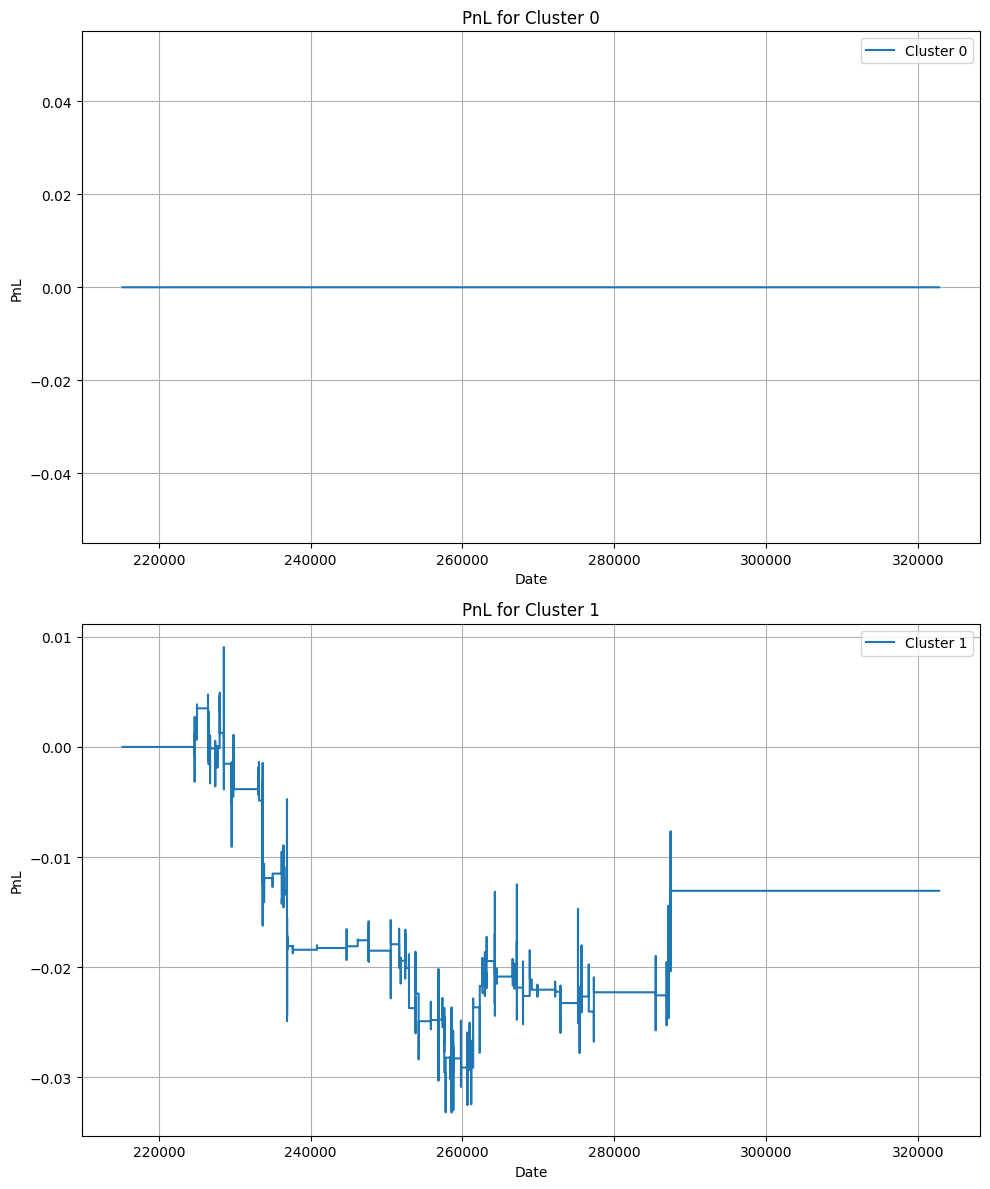

In [69]:
pnl_data = []
sharpe_list = []
result = None
trade_threshold  = 0.0005

# Create a single figure and set of subplots
fig, axes = plt.subplots(len(selected_columns_cluster), figsize=(10, 12))

for idx, data_item in enumerate(selected_columns_cluster):
    _, hold_out_cols = split_data(data_item)

    # Create and train model
    model.load_model(f"best_in_cluster_{idx}.json")

    # Make predictions
    y_hold_out = model.predict(hold_out_cols)
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print(f"Pnl ratio for cluster {idx}: {pnl}")
    # Append PnL data to the list
    pnl_data.append(pnl)
    result = return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl)
    sharpe_list.append(sharpe)

    # Plot PnL for each cluster
    if len(selected_columns_cluster) == 1:
        ax = axes
    else:
        ax = axes[idx]

    ax.plot(pnl, label=f'Cluster {idx}')
    ax.set_title(f'PnL for Cluster {idx}')
    ax.set_xlabel('Date')
    ax.set_ylabel('PnL')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [70]:
#Top 10 feature into list
feature=[]
for i in top_10_features_per_cluster:
    listToStr = ' '.join([str(elem) for elem in i])
    feature.append(listToStr)
print(feature)

['volume_obv volume_adi others_dr trend_aroon_down momentum_pvo_hist volatility_bbw trend_psar_down trend_dpo volume_cmf trend_adx', 'volume_sma_em volatility_bbw volume_vpt trend_psar_down_indicator trend_mass_index trend_psar_up volume_cmf trend_aroon_down trend_psar_up_indicator volume_fi']


In [72]:
name=[]
for i in range(len(selected_columns_cluster)):
  name.append( 'Cluster '+ str(i))

In [73]:
dict = {'Top 10 Feature' : feature, 'Best params': best_params_list, 'Best sharpe':sharpe_list}
df_result = pd.DataFrame(dict, index=name)
df_result

,Top 10 Feature,Best params,Best sharpe
Cluster 0,volume_obv volume_adi others_dr trend_aroon_do...,"{'max_depth': 3, 'learning_rate': 0.0275316557...",0.000000
Cluster 1,volume_sma_em volatility_bbw volume_vpt trend_...,"{'max_depth': 5, 'learning_rate': 0.0711952965...",-0.148142


In [74]:
#DataFrame of Pnl hold out
df_pnl = pd.DataFrame()
for i in range(len(selected_columns_cluster)):
  df_pnl[name[i]]=pnl_data[i]
df_pnl

,Cluster 0,Cluster 1
215209,NaN,NaN
215210,NaN,NaN
215211,NaN,NaN
215212,NaN,NaN
215213,NaN,NaN
...,...,...
322807,0.0,-0.013065
322808,0.0,-0.013065
322809,0.0,-0.013065
322810,0.0,-0.013065
